<a href="https://colab.research.google.com/github/fakhruddinarif/imgpro-compvis/blob/main/quiz2/CarLicensePlateOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **OCR Without YOLOv8**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/car-plate-detection/versions/1


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [ ]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Get image filename from tag <filename>
    image_filename = root.find('filename').text

    # Get bounding box from tag <bndbox>
    bndbox = root.find('object').find('bndbox')
    x_min = int(bndbox.find('xmin').text)
    y_min = int(bndbox.find('ymin').text)
    x_max = int(bndbox.find('xmax').text)
    y_max = int(bndbox.find('ymax').text)

    bbox = (x_min, y_min, x_max - x_min, y_max - y_min)

    # Using the image file name as a label
    plate_text = image_filename.split('.')[0]  # Retrieving names without extensions

    return image_filename, plate_text, bbox

def load_dataset(images_folder, annotations_folder): # Load dataset and pre-processing
    images = []
    labels = []

    for xml_file in os.listdir(annotations_folder):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotations_folder, xml_file)
            image_filename, plate_text, bbox = parse_annotation(xml_path)

            # Load image from folder images
            image_path = os.path.join(images_folder, image_filename)
            image = cv2.imread(image_path)

            if image is not None:
                # Crop bounding box and preprocess
                x, y, w, h = bbox
                cropped_image = image[y:y+h, x:x+w]
                resized_image = cv2.resize(cropped_image, (128, 64))
                grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
                normalized_image = grayscale_image / 255.0
                images.append(normalized_image)
                labels.append(plate_text)

    images = np.array(images).reshape(-1, 64, 128, 1)
    return images, labels

IMAGES_PATH = '/root/.cache/kagglehub/datasets/andrewmvd/car-plate-detection/versions/1/images/'
ANNOTATIONS_PATH = '/root/.cache/kagglehub/datasets/andrewmvd/car-plate-detection/versions/1/annotations/'

images, labels = load_dataset(IMAGES_PATH, ANNOTATIONS_PATH)

print("Number of images:", len(images))
print("Number of labels:", len(labels))

print(f"Images Shape: {images.shape}")

Number of images: 433
Number of labels: 433
Images Shape: (433, 64, 128, 1)


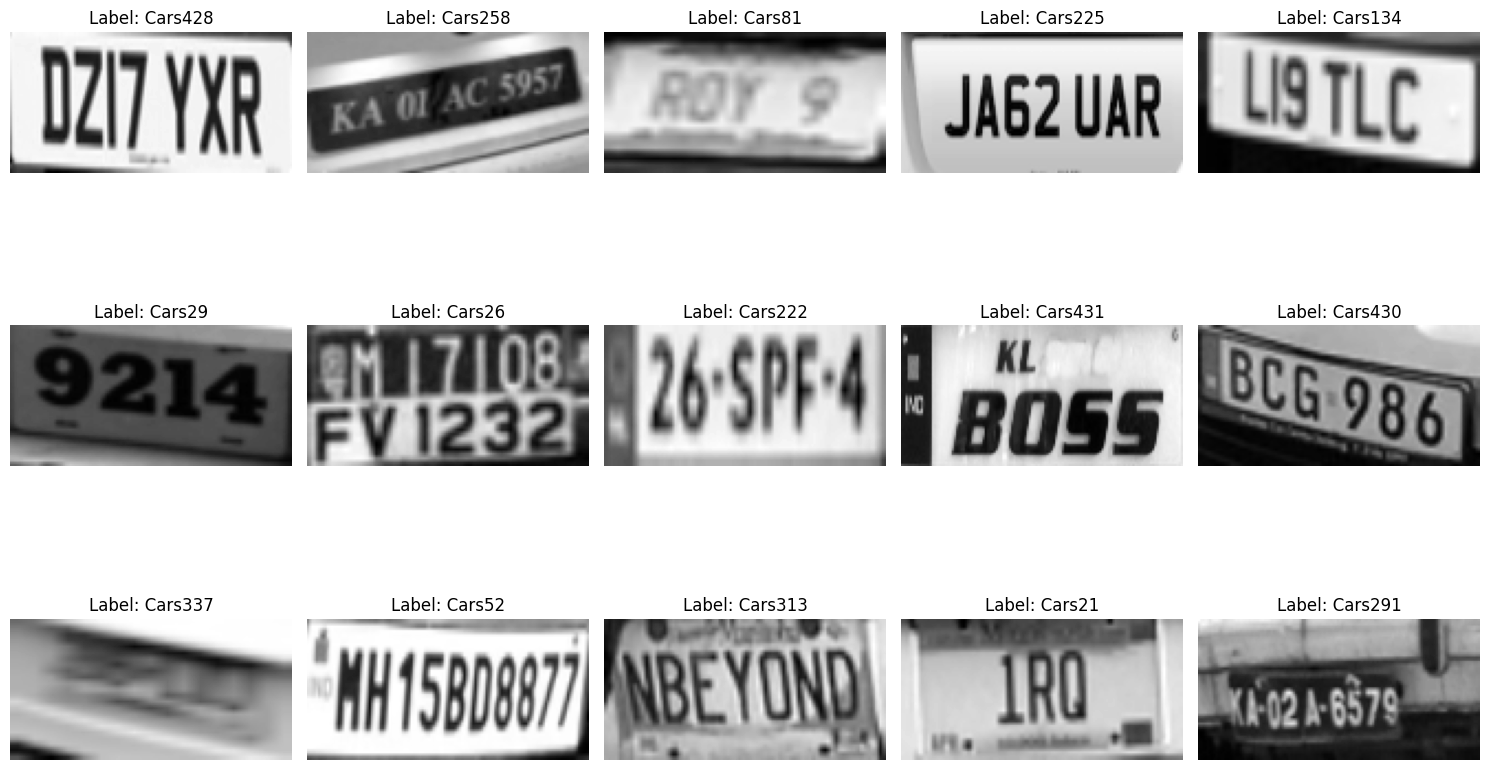

In [ ]:
# Get 15 images random

fig, axes = plt.subplots(3, 5, figsize=(15, 10))

for i in range(3):
    for j in range(5):
        random_index = random.randint(0, len(images) - 1)
        image = images[random_index]
        label = labels[random_index]

        axes[i, j].imshow(image, cmap='gray')
        axes[i, j].set_title(f"Label: {label}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Encoding Label
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(labels)
encoded_labels = tokenizer.texts_to_sequences(labels)
padded_labels = tf.keras.preprocessing.sequence.pad_sequences(encoded_labels, padding='post', maxlen=10)

print(f"Encoded Labels Shape: {padded_labels.shape}")

Encoded Labels Shape: (433, 10)


In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, padded_labels, test_size=0.2, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")

print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (346, 64, 128, 1)
y_train Shape: (346, 10)
X_test Shape: (87, 64, 128, 1)
y_test Shape: (87, 10)


In [ ]:
MAX_PLATE_LENGTH = 12
NUM_CLASSES = 35

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 128, 1)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(MAX_PLATE_LENGTH * NUM_CLASSES, activation='softmax'),
#     tf.keras.layers.Reshape((MAX_PLATE_LENGTH, NUM_CLASSES))
# ])

def build_model(input_shape = (64, 128, 1), num_classes = 35):
  input_layer = tf.keras.layers.Input(shape=input_shape, name='image_input')
  x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)

  x = tf.keras.layers.Reshape((-1, x.shape[-1]))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x)

  model = tf.keras.Model(inputs=input_layer, outputs=x)
  return model

model = build_model(NUM_CLASSES)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

ValueError: Cannot convert '35' to a shape.

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 577ms/step - accuracy: 0.2367 - loss: 3.0681 - val_accuracy: 0.6402 - val_loss: 1.2577
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - accuracy: 0.5668 - loss: 1.7638 - val_accuracy: 0.7586 - val_loss: 0.7816
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 520ms/step - accuracy: 0.7215 - loss: 1.1034 - val_accuracy: 0.7437 - val_loss: 0.6913
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 402ms/step - accuracy: 0.7417 - loss: 0.9078 - val_accuracy: 0.7540 - val_loss: 0.6654
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step - accuracy: 0.7495 - loss: 0.8506 - val_accuracy: 0.7552 - val_loss: 0.6670
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - accuracy: 0.7530 - loss: 0.7889 - val_accuracy: 0.7437 - val_loss: 0.6759
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 567ms/step - accuracy: 0.7595 - loss: 0.7706 - val_accuracy: 0.7437 - val_loss: 0.6734
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.7502 - loss: 0.7733 - val_accuracy: 0.

In [ ]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss * 100:.2f} %")
print(f"Train Accuracy: {train_accuracy * 100:.2f} %")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss * 100:.2f} %")
print(f"Test Accuracy: {test_accuracy * 100:.2f} %")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7731 - loss: 0.6491
Train Loss: 65.26 %
Train Accuracy: 77.25 %
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7536 - loss: 0.6541
Test Loss: 65.55 %
Test Accuracy: 75.63 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


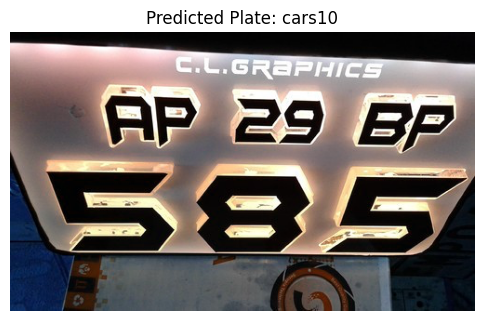

Predicted Plate: cars10


In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# Predict for Licence Plate
def predict_licence_plate(path):
    # Load and preprocess the image
    image = cv2.imread(os.path.join(IMAGES_PATH, path))
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_resized = cv2.resize(image_gray, (128, 64))
    image_input = image_resized.reshape(1, 64, 128, 1) / 255.0  # Normalisasi

    # Make prediction
    prediction = model.predict(image_input)
    predicted_indices = np.argmax(prediction, axis=-1)[0]  # Ambil hasil prediksi sebagai array 1D
    decoded_label = ''.join([tokenizer.index_word.get(int(idx), '') for idx in predicted_indices]).strip()

    # Display the image with the predicted license plate
    plt.figure(figsize=(6, 4))
    plt.imshow(image, cmap='gray')  # Menampilkan gambar asli
    plt.title(f"Predicted Plate: {decoded_label}")
    plt.axis('off')
    plt.show()

    return decoded_label

# Select a random image from the directory and predict
random_image_path = random.choice(os.listdir(IMAGES_PATH))
predicted_plate = predict_licence_plate(random_image_path)
print(f"Predicted Plate: {predicted_plate}")

## **OCR With YOLOv8**

In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="dvKfdXA0e48FDs3NNlri")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(6)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-6 in yolov8:: 100%|██████████| 20262/20262 [00:02<00:00, 7981.73it/s]


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 16.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Inisialisasi model YOLOv8
model = YOLO("yolov8n.pt")  # Anda bisa memilih model lain seperti yolov8s.pt, yolov8m.pt, dll.

# Melatih model dengan dataset
model.train(data="/content/License-Plate-Recognition-6/data.yaml", epochs=10, imgsz=640, batch=256)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 70.0MB/s]


Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/License-Plate-Recognition-6/data.yaml, epochs=10, time=None, patience=100, batch=256, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/License-Plate-Recognition-6/train/labels... 7057 images, 5 backgrounds, 0 corrupt: 100%|██████████| 7057/7057 [00:05<00:00, 1218.78it/s]


train: New cache created: /content/License-Plate-Recognition-6/train/labels.cache


val: Scanning /content/License-Plate-Recognition-6/valid/labels... 2048 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2048/2048 [00:01<00:00, 1229.13it/s]

val: New cache created: /content/License-Plate-Recognition-6/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.002), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.251      2.847      1.125        148        640: 100%|██████████| 28/28 [23:30<00:00, 50.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:08<00:00, 32.11s/it]


                   all       2048       2195      0.949     0.0339      0.727      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.177      1.601      1.028        153        640: 100%|██████████| 28/28 [23:32<00:00, 50.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:09<00:00, 32.47s/it]


                   all       2048       2195      0.961      0.326      0.628      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.176      1.236      1.041        153        640: 100%|██████████| 28/28 [23:32<00:00, 50.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:12<00:00, 33.14s/it]


                   all       2048       2195      0.832       0.71      0.776      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.172      0.977      1.051        150        640: 100%|██████████| 28/28 [23:34<00:00, 50.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:11<00:00, 32.89s/it]


                   all       2048       2195      0.909      0.773      0.846      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.149     0.8032      1.048        151        640: 100%|██████████| 28/28 [23:45<00:00, 50.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:06<00:00, 31.75s/it]

                   all       2048       2195      0.951      0.902      0.927      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.132     0.6941      1.043        148        640: 100%|██████████| 28/28 [23:49<00:00, 51.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [02:09<00:00, 32.44s/it]

                   all       2048       2195       0.98      0.908      0.941      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.088     0.6557      1.045        270        640:  11%|█         | 3/28 [02:41<22:23, 53.75s/it]


KeyboardInterrupt: 

In [ ]:
model.save('car_license_detection_model.pt')

In [ ]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 12,675 gradients, 8.1 GFLOPs

Dataset 'coco.yaml' images not found ⚠️, missing path '/content/datasets/coco/val2017.txt'


100%|██████████| 169M/169M [00:00<00:00, 303MB/s]
Unzipping /content/datasets/coco2017labels-segments.zip to /content/datasets/coco...: 100%|██████████| 122232/122232 [00:20<00:00, 6067.20file/s]

KeyboardInterrupt: 


image 1/1 /content/Cars1.png: 416x640 1 License_Plate, 43.7ms
Speed: 2.1ms preprocess, 43.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


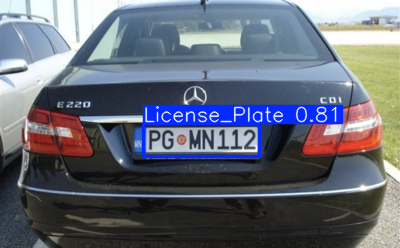

In [ ]:
# Melakukan inferensi pada gambar baru
results = model("/content/Cars1.png")

# Since 'results' is a list, iterate through it and display each result individually.
from ultralytics import YOLO

for result in results:
    # Assuming each 'result' in the list has a 'show' method
    # (e.g., it's a prediction object with an image).
    result.show()  # Menampilkan hasil deteksi

In [ ]:
!apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2min 18s (34.8 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 119628 files and directories currently installed.)
Preparing to unpack .../tesseract-

In [ ]:
import cv2
import pytesseract

def ocr_license_plate(image, bbox):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cropped_img = image[y_min:y_max, x_min:x_max]  # Potong area plat nomor

    # Gunakan Tesseract untuk OCR
    text = pytesseract.image_to_string(cropped_img, config="--psm 8")  # Mode psm 8 untuk satu baris teks
    return text

In [ ]:
from PIL import Image

# Baca gambar dengan OpenCV
image_path = "/content/Cars1.png"
image = cv2.imread(image_path)

# Dapatkan bounding box dari hasil YOLO
result = model(image_path)
for bbox in result[0].boxes.xyxy:  # Mendapatkan setiap bounding box
    text = ocr_license_plate(image, bbox)
    print("Detected License Plate Text:", text)


image 1/1 /content/Cars1.png: 416x640 1 License_Plate, 44.1ms
Speed: 2.1ms preprocess, 44.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
Detected License Plate Text: ‘PGeMN112



# **Excecute Model**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 16.3 MB/s eta 0:00:00


In [ ]:
!apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,642 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 119635 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [ ]:
from ultralytics import YOLO
import pytesseract
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saving ini_plat.jpg to ini_plat (1).jpg

0: 480x640 1 License_Plate, 98.8ms
Speed: 2.3ms preprocess, 98.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
Plat Nomor Kendaraan: [B 2156 TOR}


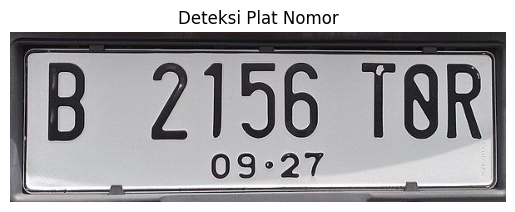

In [ ]:
model = YOLO('/content/sample_data/car_license_detection_model.pt')

def detect_license_plate(path):
  image = cv2.imread(path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  results = model.predict(image_rgb, conf=0.5)
  detections = results[0].boxes.data.cpu().numpy()

  if len(detections) == 0:
    print("Tidak Ada Plat Nomor Kendaraan Pada Gambar Tersebut")
    return

  for detection in detections:
    x_min, y_min, x_max, y_max, confidence, class_id = detection
    plate_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]

    gray_plate = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

    detected_text = pytesseract.image_to_string(gray_plate, config='--psm 7').strip()

    if detected_text:
      print(f"Plat Nomor Kendaraan: {detected_text}")
    else:
      print("Tidak dapat membaca teks pada plat nomor.")
    plt.imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
    plt.title("Deteksi Plat Nomor")
    plt.axis("off")
    plt.show()

uploaded = files.upload()
for filename in uploaded.keys():
  detect_license_plate(filename)